In [1]:
import numpy as np 
import pandas as pd 

import os
count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    if count == 1:
        print(filenames)
    count += 1

['bcn_20k_train.csv', 'bcn_20k_test.csv']


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
CLASS_MAP = {
    'NV': 0,
    'MEL': 1,
    'BCC': 2,
    'BKL': 3,
    'AK': 4,
    'SCC': 5,
    'DF': 6,
    'VASC': 7
}

IDX_TO_CLASS = {v: k for k, v in CLASS_MAP.items()}

In [1]:
data_dir = '/kaggle/input/bcn20000'

# Training data directory and csv path
train_img_dir = os.path.join(data_dir, 'BCN_20k_train/bcn_20k_train')
train_metadata_path = os.path.join(data_dir, 'bcn_20k_train.csv')

# Testing data directory and csv path
test_img_dir = os.path.join(data_dir, 'BCN_20k_test/bcn_20k_test')
test_metadata_path = os.path.join(data_dir, 'bcn_20k_test.csv')

# Load metadata
metadata = pd.read_csv(train_metadata_path)
print(f"Total training images: {len(metadata)}")
print(f"Total testing images: {len(pd.read_csv(test_metadata_path))}")
metadata.head()

NameError: name 'os' is not defined

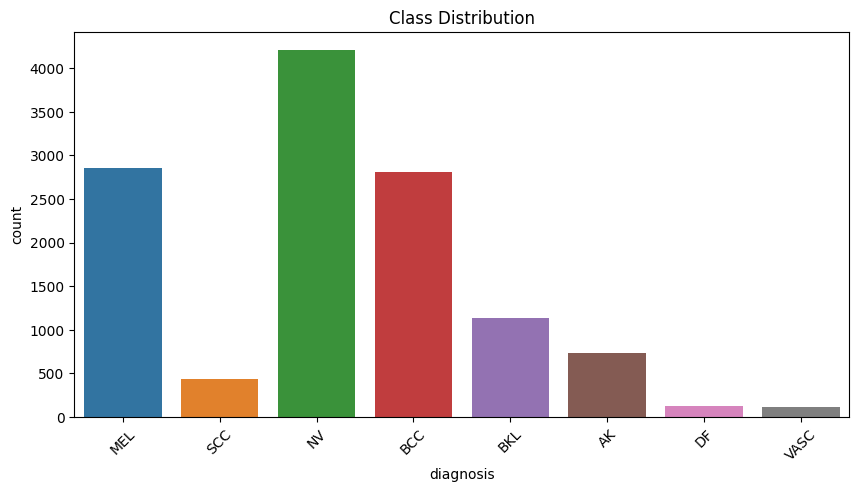

In [5]:
plt.figure(figsize=(10, 5))
sns.countplot(x='diagnosis', data=metadata)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [6]:
 # Define transformation with data augmentation
vit_transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
#Preprocessing Only for Validation
vit_transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [8]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.class_to_idx = CLASS_MAP


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['bcn_filename']
        label = CLASS_MAP[self.df.iloc[idx]['diagnosis']]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image)
    
        return {"pixel_values": image, "label": label}

In [9]:
train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata['diagnosis'],
    random_state=42
)

print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

Train samples: 9930, Validation samples: 2483


In [10]:
train_dataset = SkinLesionDataset(train_df, train_img_dir, transform=vit_transforms_train)
val_dataset = SkinLesionDataset(val_df, train_img_dir, transform=vit_transforms_val)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [12]:
print("Class to index mapping:", train_dataset.class_to_idx)

sample = train_dataset[0]
img = sample["pixel_values"]
label = sample["label"]

print("Sample image shape:", img.shape)
print("Sample label index:", label)

Class to index mapping: {'NV': 0, 'MEL': 1, 'BCC': 2, 'BKL': 3, 'AK': 4, 'SCC': 5, 'DF': 6, 'VASC': 7}
Sample image shape: torch.Size([3, 224, 224])
Sample label index: 6


In [13]:
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from datasets import Dataset
import torch

2025-06-06 20:49:36.417745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749242976.605236      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749242976.659664      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
def prepare_dataset(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img) 
        labels.append(label)
    return {'pixel_values': images, 'label': labels}

In [15]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(CLASS_MAP),
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
#from datasets import load_metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=1).numpy()
    labels = labels

    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average='macro', zero_division=0),
        "recall": recall_score(labels, predictions, average='macro', zero_division=0),
        "f1": f1_score(labels, predictions, average='macro', zero_division=0)
    }

In [18]:
training_args = TrainingArguments(
    output_dir="./vit-results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    logging_dir="./vit-logs",
    logging_steps=50,
    save_total_limit=1,
    report_to="none",
    fp16=True,
    eval_strategy="steps",  
    eval_steps=100, 
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True
)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [20]:
# Test fetching a single image from the dataset
sample = train_dataset[0]
img = sample["pixel_values"]
label = sample["label"]

print("Image shape:", img.shape)
print("Label:", label)

Image shape: torch.Size([3, 224, 224])
Label: 6


In [21]:
from tqdm import tqdm

# Test if multiple images load successfully from the dataset
for i in tqdm(range(10)):
    _ = train_dataset[i]

100%|██████████| 10/10 [00:00<00:00, 26.53it/s]


In [22]:
print("Sanity check before training:")
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

Sanity check before training:
Train size: 9930
Val size: 2483


In [23]:
print("Starting trainer...")
trainer.train()

Starting trainer...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.253400,1.181779,0.593234,0.309911,0.292053,0.272561
200,1.061000,1.032753,0.645590,0.353690,0.343201,0.337985
300,0.989300,0.975585,0.668949,0.572779,0.390077,0.405248
400,0.938200,0.925915,0.673379,0.507671,0.403072,0.403606
500,0.900200,0.889389,0.687475,0.583062,0.442430,0.474500
600,0.839800,0.874122,0.696738,0.618578,0.460662,0.495221
700,0.808300,0.833416,0.710028,0.619769,0.490700,0.506859
800,0.751100,0.810051,0.716472,0.602057,0.496353,0.525269
900,0.732900,0.781384,0.726138,0.644942,0.500674,0.536160
1000,0.722500,0.771185,0.736206,0.744916,0.539902,0.571928


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=3105, training_loss=0.604131943937661, metrics={'train_runtime': 4623.1596, 'train_samples_per_second': 10.739, 'train_steps_per_second': 0.672, 'total_flos': 3.8476841866960896e+18, 'train_loss': 0.604131943937661, 'epoch': 5.0})

In [24]:
results = trainer.evaluate()
print("Final Validation Accuracy:", results["eval_accuracy"])
model.save_pretrained("./vit-best-manual")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final Validation Accuracy: 0.801449859041482


In [25]:
for i, entry in enumerate(trainer.state.log_history):
    print(f"{i}: {entry}")

0: {'loss': 1.5465, 'grad_norm': 456801.90625, 'learning_rate': 1.968438003220612e-05, 'epoch': 0.08051529790660225, 'step': 50}
1: {'loss': 1.2534, 'grad_norm': 475934.34375, 'learning_rate': 1.9362318840579713e-05, 'epoch': 0.1610305958132045, 'step': 100}
2: {'eval_loss': 1.1817790269851685, 'eval_accuracy': 0.5932339911397503, 'eval_precision': 0.3099107093632261, 'eval_recall': 0.2920531818318907, 'eval_f1': 0.27256075150112175, 'eval_runtime': 120.1454, 'eval_samples_per_second': 20.667, 'eval_steps_per_second': 1.298, 'epoch': 0.1610305958132045, 'step': 100}
3: {'loss': 1.1552, 'grad_norm': 565514.5625, 'learning_rate': 1.9040257648953304e-05, 'epoch': 0.24154589371980675, 'step': 150}
4: {'loss': 1.061, 'grad_norm': 577280.9375, 'learning_rate': 1.8718196457326894e-05, 'epoch': 0.322061191626409, 'step': 200}
5: {'eval_loss': 1.0327529907226562, 'eval_accuracy': 0.6455900120821587, 'eval_precision': 0.35368951580056507, 'eval_recall': 0.34320115753867275, 'eval_f1': 0.33798478

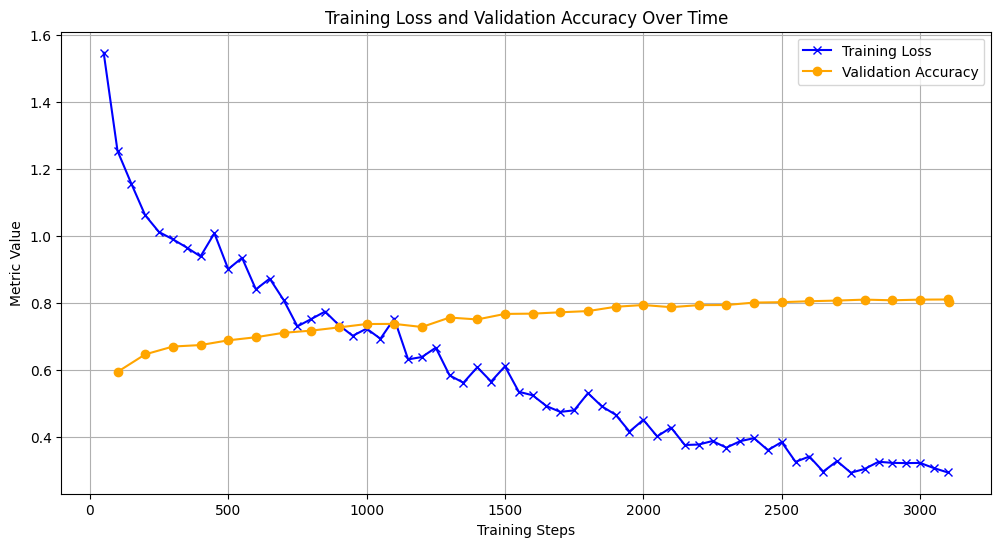

In [27]:
logs = trainer.state.log_history

# Collect training loss and steps
train_loss = [log['loss'] for log in logs if 'loss' in log and 'step' in log]
train_steps = [log['step'] for log in logs if 'loss' in log and 'step' in log]

# Collect validation accuracy and steps
val_acc = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log and 'step' in log]
val_steps = [log['step'] for log in logs if 'eval_accuracy' in log and 'step' in log]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_loss, label='Training Loss', marker='x', color='blue')
plt.plot(val_steps, val_acc, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.title("Training Loss and Validation Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Get predictions
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [29]:
# View Confusion Matrix and Class Report
# Class index to name
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Classification report
print("Classification Report:")
print(classification_report(labels, preds, target_names=list(IDX_TO_CLASS.values())))

# Confusion matrix
cm = confusion_matrix(labels, preds)

Classification Report:
              precision    recall  f1-score   support

          NV       0.85      0.89      0.87       841
         MEL       0.80      0.78      0.79       572
         BCC       0.82      0.87      0.84       562
         BKL       0.71      0.67      0.69       228
          AK       0.61      0.63      0.62       147
         SCC       0.79      0.48      0.59        86
          DF       0.67      0.24      0.35        25
        VASC       0.85      0.77      0.81        22

    accuracy                           0.80      2483
   macro avg       0.76      0.67      0.70      2483
weighted avg       0.80      0.80      0.80      2483



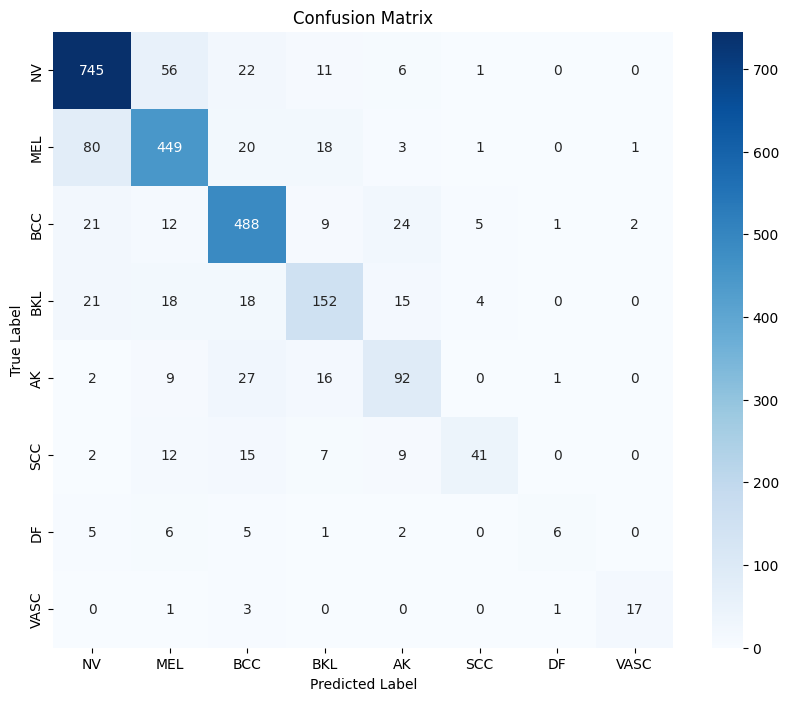

In [30]:
#Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=IDX_TO_CLASS.values(),
            yticklabels=IDX_TO_CLASS.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# 2. Sensitivity (Recall) — from classification report
report = classification_report(labels, preds, output_dict=True)
sensitivity = [report[str(i)]['recall'] for i in range(len(idx_to_class))]

In [32]:
# 3. Specificity — manual calculation
specificity = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm[:, i], i))
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificity.append(spec)

#Bar Plot — Sensitivity vs Specificity
classes = [idx_to_class[i] for i in range(len(idx_to_class))]

x = np.arange(len(classes))
width = 0.35

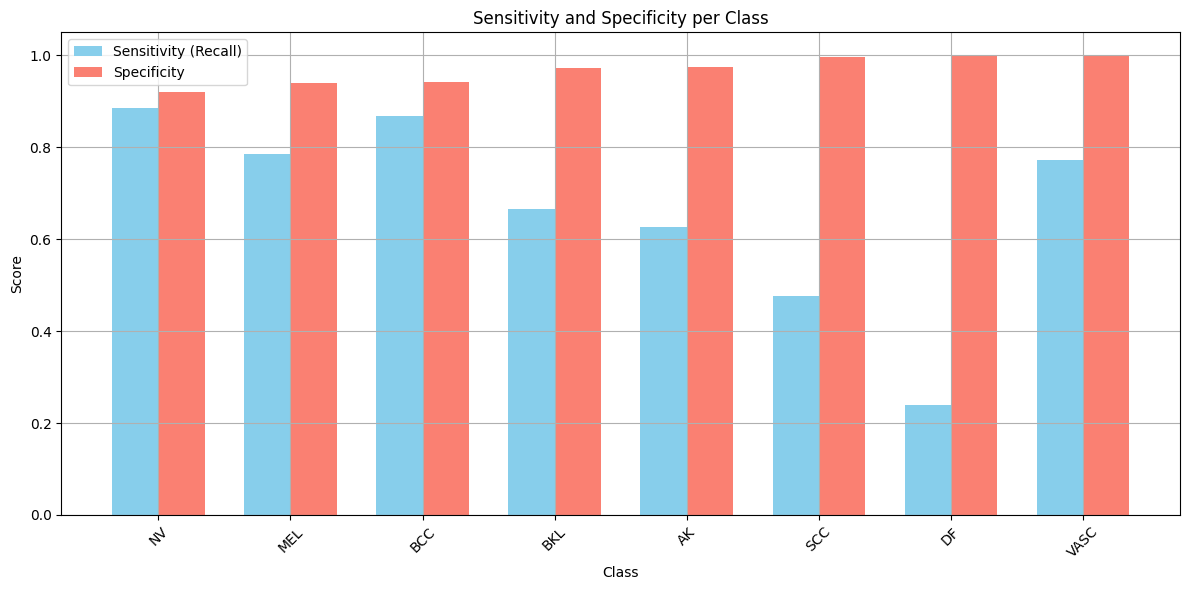

In [33]:
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, sensitivity, width, label='Sensitivity (Recall)', color='skyblue')
plt.bar(x + width/2, specificity, width, label='Specificity', color='salmon')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity per Class')
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()